В звуковой записи 1226 obuch17052021.wav на час - звуки срабатывания ПСК на 50%, на 100%, посторонние шумы (нладчик шумит, хлопает дверью, бьет молотком и т.д.), голоса и фоновые шумы. Каждый вид шума (приблизительно по 5 минут) наладчик обозначает голосом. В записи 1226 obuch_fon17052021.wav - просто фоновый шум в отсутствии людей на объекте. В записи microphoneout.wav - просто отключенный микрофон.
Требуется построить нейросеть, распознающую звуки по 6 категориям:
1. ПСК 100%
2. ПСК 50%
3. Технологические шумы.
4. Голоса
5. Фоновый шум
6. Микрофон отключен.

Частота дискретизации записи 22050 Гц. Решение будет проверено на валидационной выборке через запись wav. Допустимо применять любые библиотеки в python, решение желательно представить в блокноте Jupyter. Желательно сохранить модель (веса сети) и параметры нормализации в отдельных файлах и приложить к решению. 




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)


Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/'My Drive'/data

archive.zip  cats_dogs_dataset.zip  ssoft24.zip


In [ ]:
!pip install librosa

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/data/ssoft24.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()
!ls /content/dataset/

'1226 obuch17052021.wav'  '1226 obuch_fon17052021.wav'	 microphoneout.wav


In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv2
from skimage.io import imsave

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
os.environ['CUDA-DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA-VISIBLE_DEVICE'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
!nvidia-smi

Mon Jun  7 10:13:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
directories = '/content/dataset/'
train_dir   = '/content/dataset/train_dir/'

os.mkdir(train_dir)
os.mkdir(train_dir+'voice')
os.mkdir(train_dir+'noise')
os.mkdir(train_dir+'fon')
os.mkdir(train_dir+'micout')
os.mkdir(train_dir+'psk100')
os.mkdir(train_dir+'psk50')

In [ ]:
y, sr = librosa.load(directories+'1226 obuch17052021.wav')
y_f, sr_f = librosa.load(directories+'1226 obuch_fon17052021.wav')
y_m, sr_m = librosa.load(directories+'microphoneout.wav')



In [ ]:
print('Продолжительность записи {}с.'.format(len(y)/sr))
print('Продолжительность записи с фоном {}с.'.format(len(y_f)/sr_f))
print('Продолжительность записи с отключенным микрофоном {}с.'.format(len(y_m)/sr_m))

Продолжительность записи 3600.0с.
Продолжительность записи с фоном 900.0с.
Продолжительность записи с отключенным микрофоном 30.0с.


Объединяем все записи

Запись с отключенным микрофоном всего 30 сек. Увеличим, копированием до 5 мин

In [ ]:
y = np.append(y,y_f)
for t in range(10):
  y = np.append(y,y_m)

In [ ]:
print('Продолжительность записи {}с.'.format(len(y)/sr))

Продолжительность записи 4800.0с.



**Отметим временные метки для подготовки треноровочных данных**




Сброс ПСК 50% - 0.48-05.07

Сброс ПСК 100% - 6.30-11.38

Голоса 0.36-0.38, 6.16-6.20, 15.20-16.55 ,  18.17-18.23 , 18.39-19.02 ,  19.08-19.13, 20.50-21.36, 21.42-21.47, 21.52-21.57, 22.02-22.06, 22.49-23.30 ,  23.46-24.28,  27.40-30.04, 30.30-30.50

Фоновые шумы 60.00-75.00

Технологические шумы 12.23-15.10

Микрофон выключен 75.00-75.30




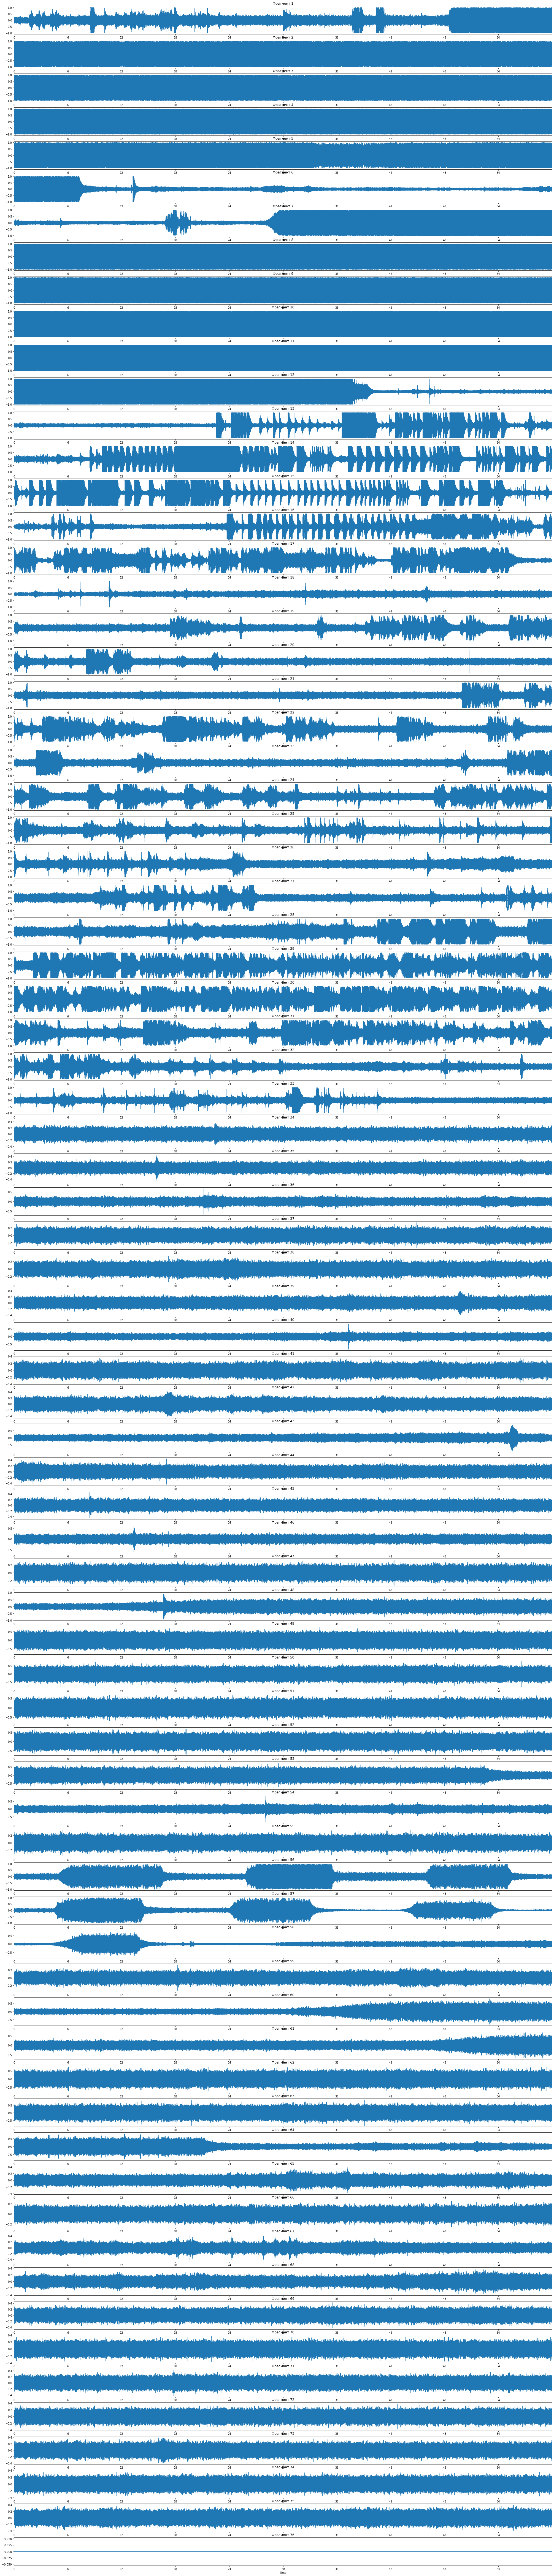

In [ ]:
plt.figure(figsize=(35,180))
for t in range(76):
  pt = 'Фрагмент {}'.format(t+1)
  plt.subplot(80,1,t+1)
  plt.title(pt)
  librosa.display.waveplot(y[sr*t*60:sr*(t+1)*60], sr=sr)


К качестве признака будем использовать mel - спектрограммы.

mel — это “психофизическая единица высоты звука”, основанная на субъективном восприятии среднестатистическими людьми. Зависит в первую очередь от частоты звука (а так же от громкости и тембра). Другими словами, эта величина, показывающая, на сколько звук определённой частоты “значим” для нас.

Сформируем список с со списками временных фрагментов

In [ ]:
# list_psk50  = ['0.48-05.07']
# list_psk100 = ['6.30-11.38']
# list_noise  = ['5.12-5.14','12.23-15.10', '24.30-27.40', '31.15-32.40', '47.15-52.55', '55.00-57.15', '59.30-60.00']
# list_voice  = ['0.36-0.38','6.16-6.20','15.20-16.55', '18.17-18.23','18.39-19.02', '19.08-19.13','20.50-21.36', '21.42-21.47', '21.52-21.57','22.02-22.06','22.49-23.30', '23.46-24.28',  '27.40-30.04', '30.30-30.50']
# list_fon    = ['32.40-47.15', '60.00-75.00']
# list_micout = ['75.00-75.30']

list_psk50  = ['0.48-05.07']
list_psk100 = ['6.30-11.38']
list_noise  = ['12.23-15.10']
list_voice  = ['0.36-0.38','6.16-6.20','15.20-16.55', '18.17-18.23','18.39-19.02', '19.08-19.13','20.50-21.36', '21.42-21.47', '21.52-21.57','22.02-22.06','22.49-23.30', '23.46-24.28',  '27.40-30.04', '30.30-30.50']
list_fon    = ['60.00-75.00']
list_micout = ['75.00-80.00']

list_all    = [list_psk50, list_psk100, list_noise, list_voice, list_fon, list_micout]


def time_to_discr(t,sr): 
 
  time_list = t.split('-')
  time1 = time_list[0].split('.')
  time2 = time_list[1].split('.')
  freq1 =int(time1[0])*60*sr+int(time1[1])*sr
  freq2 =int(time2[0])*60*sr+int(time2[1])*sr
  

  return freq1, freq2

In [173]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

Объединение категорий звуков в один массив 

In [ ]:
def get_mass(l):
  arr = np.empty(shape=[0, 0])
  for lin in l:
    f1,f2 = time_to_discr(lin, sr=sr)
    arr = np.append(arr, y[f1:f2])
    
  return arr

In [200]:
def convert_mel(freq, sr=22050, n_fft=8192):
  mel = librosa.feature.melspectrogram(freq,sr=sr, n_fft=8192)  
  mel = librosa.power_to_db(mel)
  mel = scale_minmax(mel, 0, 255).astype(np.uint8)
  mel = np.flip(mel, axis=0) 
  
  return mel



In [ ]:
psk50_np  = get_mass(list_all[0])
psk100_np = get_mass(list_all[1])
noise_np  = get_mass(list_all[2])
voice_np  = get_mass(list_all[3])
fon_np    = get_mass(list_all[4])
micout_np = get_mass(list_all[5])


Так выглядит фрагмент мел - спектрограммы с голосом

[[166 165 164 ...   3   4   5]
 [160 160 158 ...   3   4   4]
 [168 167 165 ...   8   7   7]
 ...
 [167 167 166 ... 127 129 130]
 [190 189 186 ... 136 138 138]
 [209 208 205 ... 152 152 153]]


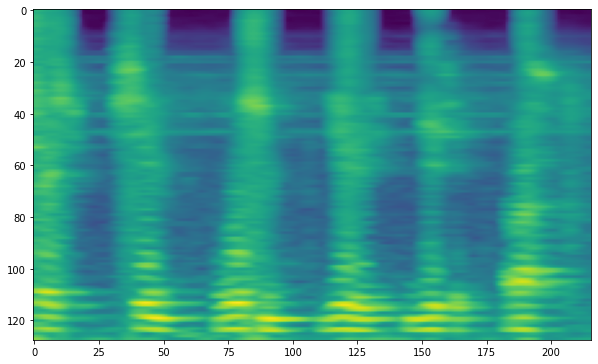

In [201]:

mel = convert_mel(voice_np[sr*20:sr*25],sr=sr, n_fft=8192)
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
plt.imshow(mel)
cv2.imwrite('1_mel.png', mel)

mel.shape
print(mel)


Аугментируем набор спектрограмм, возьмем участки разных размеров.
Будем использовать фреймы разной длины от 10 до 60 секунд

In [202]:
time_min  = 10
time_max  = 60
time_step = 1

def prepare_dataset(a_type, fname, sr=sr):
  plt.figure(figsize=(200,200))
  pos = 0
  
  for s in range(0, int(a_type.shape[0]/sr)-time_max, 10):
    for ts in range(time_min, time_max+1, 10):
      pos +=1     

      xmin = s
      xmax = xmin+ts
      mel = convert_mel(a_type[sr*xmin:sr*xmax],sr=sr, n_fft=8192)      
      cv2.imwrite(train_dir+fname+str(pos)+'_mel.jpg', mel)
      # imsave(train_dir+fname+str(pos)+'_mel.jpg', mel)
      # plt.subplot(5,100,pos)
      # plt.imshow(mel)




Сохраним изображения датасета в отдельные папки по классам

In [203]:

prepare_dataset(voice_np, fname='voice/')
prepare_dataset(noise_np, fname='noise/')
prepare_dataset(fon_np, fname='fon/')
prepare_dataset(micout_np, fname='micout/')
prepare_dataset(psk50_np, fname='psk50/')
prepare_dataset(psk100_np, fname='psk100/')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<Figure size 14400x14400 with 0 Axes>

<Figure size 14400x14400 with 0 Axes>

<Figure size 14400x14400 with 0 Axes>

<Figure size 14400x14400 with 0 Axes>

<Figure size 14400x14400 with 0 Axes>

<Figure size 14400x14400 with 0 Axes>

In [205]:


BATCH_SIZE = 16
train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(192,360),
                                                          class_mode='categorical')




classes = train_data_gen.class_indices
print(classes)

Found 1218 images belonging to 6 classes.
{'fon': 0, 'micout': 1, 'noise': 2, 'psk100': 3, 'psk50': 4, 'voice': 5}


Функция возвращает название предсказанного класса

In [206]:
def get_class_name(classes, predict_class):
  for p in classes:
    if classes[p] == predict_class:
      return(p) 



Отобразим несколько элементов из датасета

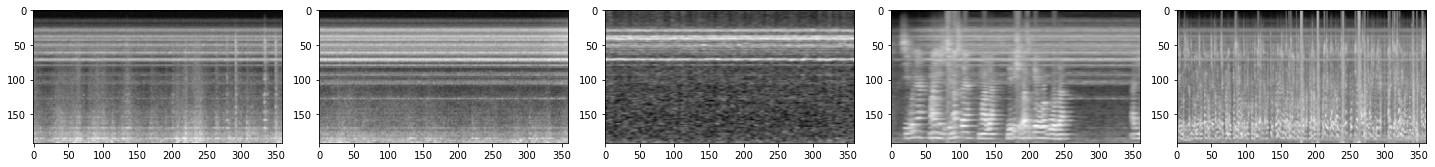

In [217]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)    
  plt.tight_layout()
  plt.show()

augmented_images = [train_data_gen[i][0][0] for i in range(5)]
plotImages(augmented_images)

Создадим модель нейронной сети со сверточными и полносвязными слоями. Будем использовать дропаут чтобы избежать переобучения, т.к. тренировочных даных не так много

In [218]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(192, 360, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [219]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Обучение модели на 10 эпохах

In [220]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=76,
    epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
76/76 [==============================] - 7s 82ms/step - loss: 0.7454 - accuracy: 0.7404
Epoch 2/10
76/76 [==============================] - 6s 81ms/step - loss: 0.1073 - accuracy: 0.9667
Epoch 3/10
76/76 [==============================] - 6s 81ms/step - loss: 0.0273 - accuracy: 0.9925
Epoch 4/10
76/76 [==============================] - 6s 80ms/step - loss: 0.0193 - accuracy: 0.9975
Epoch 5/10
76/76 [==============================] - 6s 80ms/step - loss: 0.0279 - accuracy: 0.9917
Epoch 6/10
76/76 [==============================] - 6s 81ms/step - loss: 0.0187 - accuracy: 0.9958
Epoch 7/10
76/76 [==============================] - 6s 80ms/step - loss: 0.0145 - accuracy: 0.9958
Epoch 8/10
76/76 [==============================] - 6s 80ms/step - loss: 0.0198 - accuracy: 0.9967
Epoch 9/10
76/76 [==============================] - 6s 80ms/step - loss: 0.0031 - accuracy: 0.9992
Epoch 10/10
76/76 [==============================] - 6s 80ms/step - loss: 0.0052 - accuracy: 0.9983


Визуализируем историю обучения

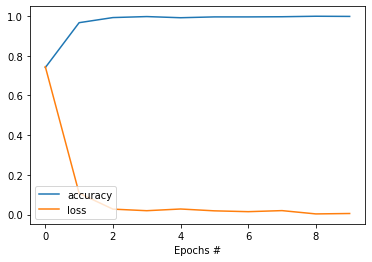

In [221]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['loss'], label ='loss')
plt.xlabel('Epochs #')
plt.legend(loc ='lower left')

Сохраним модель и веса в файл

In [222]:
model.save(directories+'model/audio.h5')
model_json = model.to_json()
json_file = open(directories+"model/audio.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights(directories+"model/audio_weight.h5")

Проверим на тестовом изображении

Ответ нейросети:
 [[2.8236138e-09 6.6341730e-15 8.3932309e-07 8.0593403e-14 1.6706436e-16
  9.9999917e-01]]
Предсказанный класс: voice


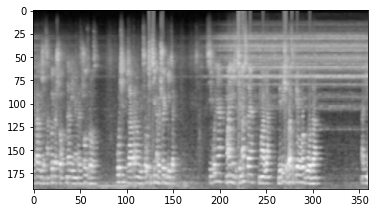

In [230]:
img=cv2.imread('voice/26_mel.jpg')
img = cv2.resize(img, (360,192))
img = np.expand_dims(img, 0)
plt.imshow(img[0])
img  = img/255
predict = model.predict(img)
plt.imshow(img[0])
answer = get_class_name(classes, np.argmax(predict))

print('Ответ нейросети:\n {}'.format(predict))
print('Предсказанный класс: {}'.format(answer))

In [229]:

predict

array([[2.8236138e-09, 6.6341730e-15, 8.3932309e-07, 8.0593403e-14,
        1.6706436e-16, 9.9999917e-01]], dtype=float32)